In [1]:
import functools
import os
import pandas as pd
import e3x
import flax.linen as nn
import jax
import numpy as np
import optax
# Disable future warnings.
import warnings
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.set_cmap('bwr')

import jax.numpy as jnp
from jax import jit, grad
from jax import vmap

NATOMS = 60
batch_size = 16

/tmp/ipykernel_27021/3860724702.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<Figure size 640x480 with 0 Axes>

In [2]:
def evaluate_dc(batch, dipo, mono, batch_size, plot=False, rcut=10000):
    esp_dc_pred = esp_mono_loss_pots(dipo, mono, batch['esp'], 
                             batch['vdw_surface'], batch['mono'], 
                             batch_size)

    mono_pred =  esp_loss_pots(batch['positions'], batch['mono'], batch['esp'],
                        batch['vdw_surface'], batch['mono'], batch_size)

    non_zero = np.nonzero(batch["mono"])

    if plot:
    
        plt.scatter(batch["mono"][non_zero], 
                    mono.sum(axis=-1).squeeze()[non_zero])
        loss = esp_loss_eval(batch["mono"][non_zero], mono.sum(axis=-1).squeeze()[non_zero], None)
        plt.title(loss)
        plt.plot([-1,1],[-1,1],c="k",alpha=0.5)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.show()
        
        for id in range(batch_size):
            plt.scatter(esp_dc_pred[id][:batch['ngrid'][id]],
                        batch['esp'][id][:batch['ngrid'][id]], alpha=0.1)
     
        ax = plt.gca()
        plt.xlim(-0.1, 0.1)
        plt.ylim(-0.1, 0.1)
        plt.plot([-1,1],[-1,1],c="k",alpha=0.5)
        ax.set_aspect("equal")
        plt.show()

    esp_errors = []
    
    for mbID in range(batch_size):
        xyzs = batch['positions'].reshape(batch_size,60, 3)
        vdws = batch['vdw_surface'][mbID][:batch['ngrid'][mbID]]
        diff = xyzs[mbID][:, None, :] - vdws[None, :, :]
        r = np.linalg.norm(diff, axis=-1) 
        min_d = np.min(r, axis=-2)
        wheremind = np.where( min_d < rcut, min_d, 0)
        idx_cut = np.nonzero(wheremind)[0]
        loss1 = esp_loss_eval(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut], 
                      batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut],
                      batch['ngrid'][mbID])
        loss2 = esp_loss_eval(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut], 
                      batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut],
                      batch['ngrid'][mbID])
        esp_errors.append([loss1, loss2])

        if plot:
            
            fig = plt.figure(figsize=(12,6))
            
            ax1 = fig.add_subplot(151, projection='3d')
            s = ax1.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax1.set_title(f"GT {mbID}")
            
    
            ax2 = fig.add_subplot(152, projection='3d')
            s = ax2.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax2.set_title(loss1)
            
            ax4 = fig.add_subplot(153, projection='3d')
            s = ax4.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut]
                                        - batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]
                                        ), 
                           vmin=-0.015, vmax=0.015)
    
    
            ax3 = fig.add_subplot(154, projection='3d')
            s = ax3.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax3.set_title(loss2)
    
            ax5 = fig.add_subplot(155, projection='3d')
            s = ax5.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut]
                                        - batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]
                                        ), 
                           vmin=-0.015, vmax=0.015)
    
    
    
            for _ in [ax1,ax2,ax3]:
                _.set_xlim(-10,10)
                _.set_ylim(-10,10)
                _.set_zlim(-10,10)
            plt.show()
        
    return esp_errors


In [3]:
from esp_net import *

def nan_safe_coulomb_potential(q, r):
    potential = jnp.where(jnp.isnan(r) | (r == 0.0), 0.0, q / (r * 1.88973))
    return potential


def calc_esp(charge_positions, charge_values, grid_positions, mono):
    chg_mask = jnp.where(mono != 0, 1.0, 0.0)
    # Expand the grid positions and charge positions to compute all pairwise differences
    diff = grid_positions[:, None, :] - charge_positions[None, :, :]
    # Compute the Euclidean distance between each grid point and each charge
    r = jnp.linalg.norm(diff, axis=-1)
    C = nan_safe_coulomb_potential((chg_mask * charge_values)[None, :], r)
    V = jnp.sum(C, axis=-1)
    return V

def esp_loss_eval(pred, target, ngrid):
    target = target.flatten()
    esp_non_zero = np.nonzero(target)
    l2_loss = optax.l2_loss(pred[esp_non_zero], target[esp_non_zero])
    esp_loss = np.mean(l2_loss)
    esp_loss = esp_loss * 1  
    return esp_loss
    
batched_electrostatic_potential = vmap(calc_esp, in_axes=(0, 0, 0, 0), out_axes=0)


def clip_colors(c):
    return np.clip(c, -0.015, 0.015)


@functools.partial(jax.jit, static_argnames=('batch_size', 'esp_w'))
def esp_mono_loss(dipo_prediction, mono_prediction, esp_target,
                  vdw_surface, mono, batch_size, esp_w):
    """
    """
    nonzero = jnp.nonzero(mono, size=batch_size * 60)
    l2_loss_mono = optax.l2_loss(mono_prediction.sum(axis=-1), mono)
    mono_loss = jnp.mean(l2_loss_mono[nonzero])

    d = dipo_prediction.reshape(batch_size, NATOMS, 3, n_dcm)
    d = jnp.moveaxis(d, -1, -2)
    d = d.reshape(batch_size, NATOMS * n_dcm, 3)
    mono = jnp.repeat(mono.reshape(batch_size, NATOMS), n_dcm, axis=-1)
    m = mono_prediction.reshape(batch_size, NATOMS * n_dcm)

    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono).flatten()
    esp_target = esp_target.flatten()
    esp_non_zero = jnp.nonzero(esp_target, size=batch_size * 3143)

    l2_loss = optax.l2_loss(batched_pred, esp_target)
    esp_loss = jnp.mean(l2_loss[esp_non_zero])
    esp_loss = esp_loss * esp_w
    return esp_loss + mono_loss


def esp_mono_loss_pots(dipo_prediction, mono_prediction, esp_target,
                       vdw_surface, mono, batch_size):
    """
    """
    d = dipo_prediction.reshape(batch_size, NATOMS, 3, n_dcm)
    d = jnp.moveaxis(d, -1, -2)
    d = d.reshape(batch_size, NATOMS * n_dcm, 3)
    mono = jnp.repeat(mono.reshape(batch_size, NATOMS), n_dcm, axis=-1)
    m = mono_prediction.reshape(batch_size, NATOMS * n_dcm)

    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono)

    return batched_pred


def esp_loss_pots(dipo_prediction, mono_prediction,
                  esp_target, vdw_surface, mono, batch_size):
    d = dipo_prediction.reshape(batch_size, NATOMS, 3)
    mono = mono.reshape(batch_size, NATOMS)
    m = mono_prediction.reshape(batch_size, NATOMS)
    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono)

    return batched_pred


def mean_absolute_error(prediction, target, batch_size):
    nonzero = jnp.nonzero(target, size=batch_size * 60)
    return jnp.mean(jnp.abs(prediction[nonzero] - target[nonzero]))

<Figure size 640x480 with 0 Axes>

In [4]:
NATOMS = 60
class MessagePassingModel(nn.Module):
    features: int = 32
    max_degree: int = 2
    num_iterations: int = 3
    num_basis_functions: int = 8
    cutoff: float = 5.0
    max_atomic_number: int = 17
    n_dcm: int = 4

    def mono(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments,
             batch_size):
        # 1. Calculate displacement vectors.
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

        # 2. Expand displacement vectors in basis functions.
        basis = e3x.nn.basis(
            # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
        )

        x = e3x.nn.Embed(num_embeddings=self.max_atomic_number + 1,
                         features=self.features)(atomic_numbers)

        # 4. Perform iterations (message-passing + atom-wise refinement).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Final iteration.
                y = e3x.nn.MessagePass(max_degree=max_degree,
                                       include_pseudotensors=False
                                       )(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            else:
                y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)

            y = e3x.nn.add(x, y)
            # Atom-wise refinement MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features)(y)
            # Residual connection.
            x = e3x.nn.add(x, y)

        x = e3x.nn.TensorDense(
            features=n_dcm,
            max_degree=1,
            include_pseudotensors=False,
        )(x)

        atomic_mono = e3x.nn.change_max_degree_or_type(x,
                                                       max_degree=0,
                                                       include_pseudotensors=False)
        element_bias = self.param('element_bias',
                                  lambda rng, shape: jnp.zeros(shape),
                                  (self.max_atomic_number + 1))
        atomic_mono = nn.Dense(n_dcm, use_bias=False,
                               #kernel_init=jax.nn.initializers.zeros
                               )(atomic_mono)
        atomic_mono = atomic_mono.squeeze(axis=1)
        atomic_mono = atomic_mono.squeeze(axis=1)
        atomic_mono += element_bias[atomic_numbers][:, None]
        atomic_dipo = x[:, 1, 1:4, :]
        atomic_dipo = e3x.nn.silu(atomic_dipo)
        atomic_dipo = jnp.clip(atomic_dipo, a_min=-0.3, a_max=0.3)
        atomic_dipo += positions[:, :, None]

        return atomic_mono, atomic_dipo

    @nn.compact
    def __call__(self, atomic_numbers, positions, dst_idx, src_idx,
                 batch_segments=None, batch_size=None):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1

        return self.mono(atomic_numbers, positions, dst_idx, src_idx, batch_segments,
                         batch_size)

# Data

In [5]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(
    0
), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    10000 - 16,
    16,
    filename="data/qm9-esp10000.npz")

R (10000, 60, 3)
Z (10000, 60)
N (10000,)
mono (10000, 60, 1)
esp (10000, 3143)
n_grid (10000,)
vdw_surface (10000, 3143, 3)
10000
...
...
atomic_numbers (9984, 60)
ngrid (9984,)
positions (9984, 60, 3)
mono (9984, 60, 1)
esp (9984, 3143)
vdw_surface (9984, 3143, 3)
...
atomic_numbers (16, 60)
positions (16, 60, 3)
mono (16, 60, 1)
ngrid (16,)
esp (16, 3143)
vdw_surface (16, 3143, 3)


In [6]:
valid_batches = prepare_batches(data_key, valid_data, batch_size)
print(len(valid_batches))

1


In [7]:
train_batches = prepare_batches(data_key, train_data, batch_size)
print(len(train_batches))

624


#  DCM1

In [772]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 1
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle("checkpoints/dcm1-10000.0/4-0.07652133703231812-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm1-10.0/8-0.00036029628245159984-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm1-100.0/21-0.0014323507202789187-esp_params.pkl")

message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 1
)

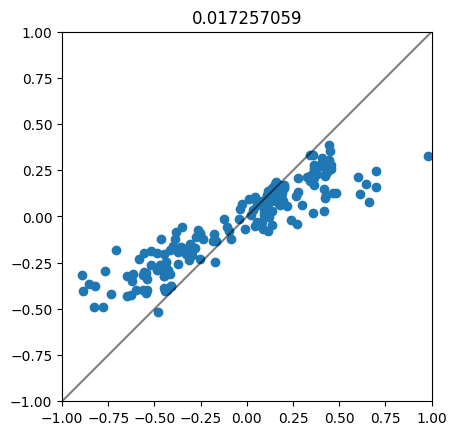

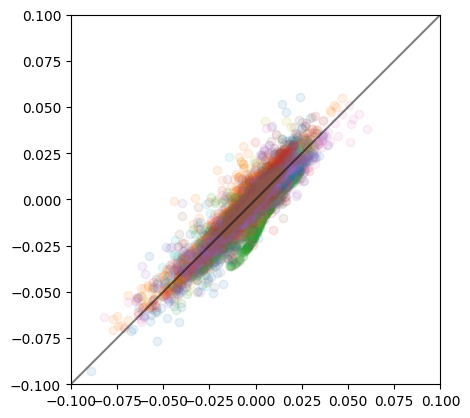

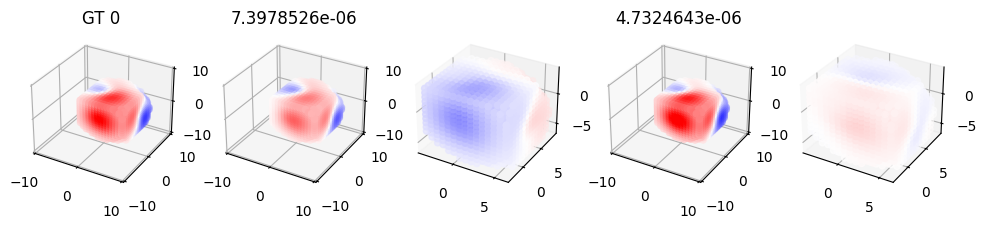

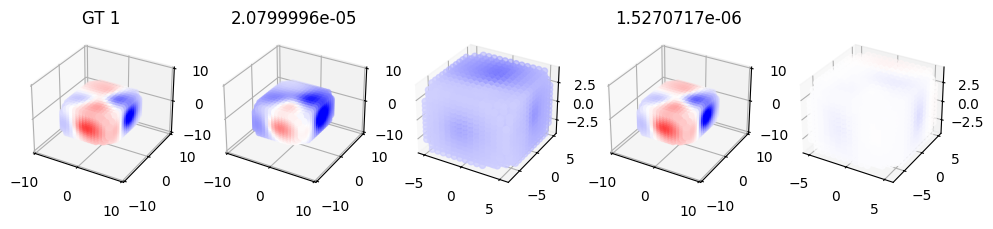

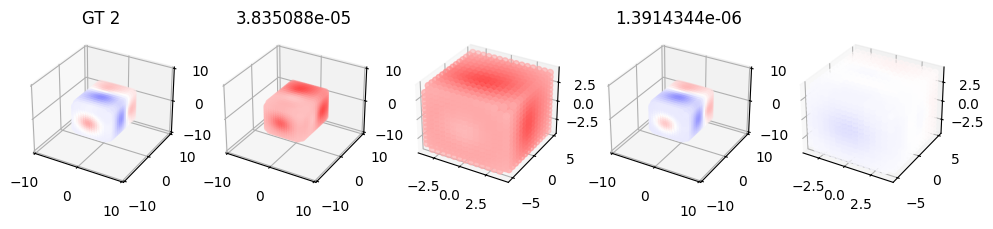

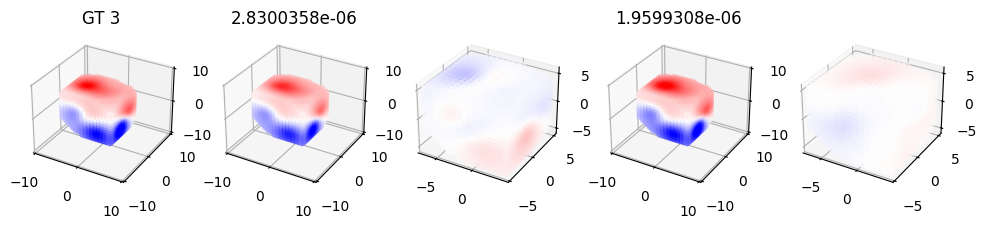

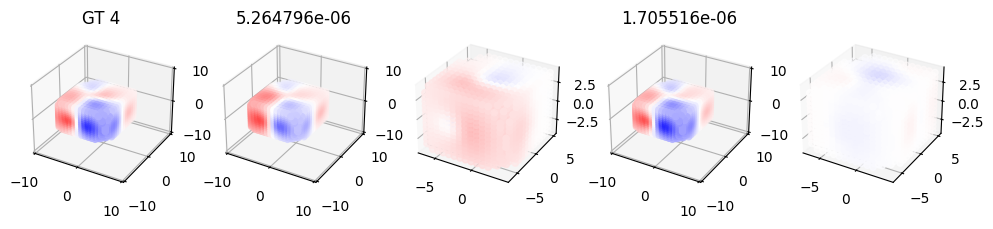

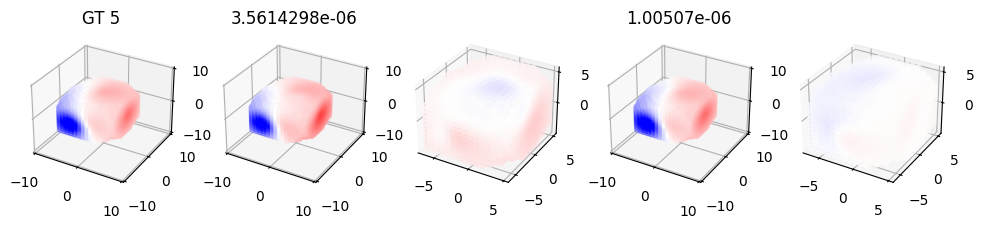

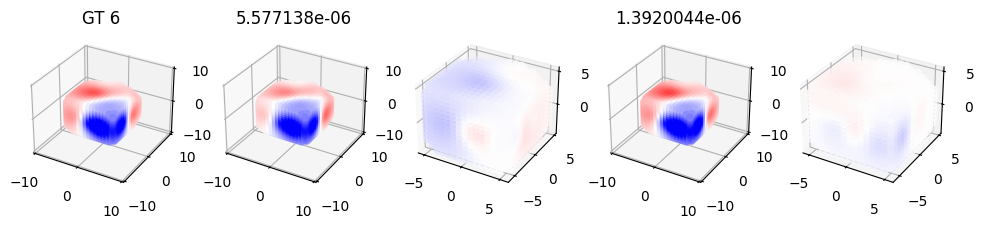

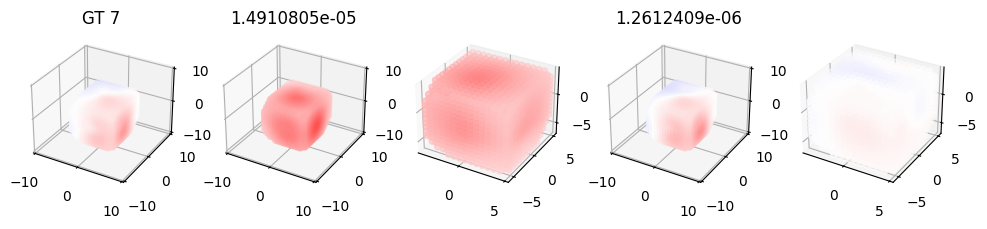

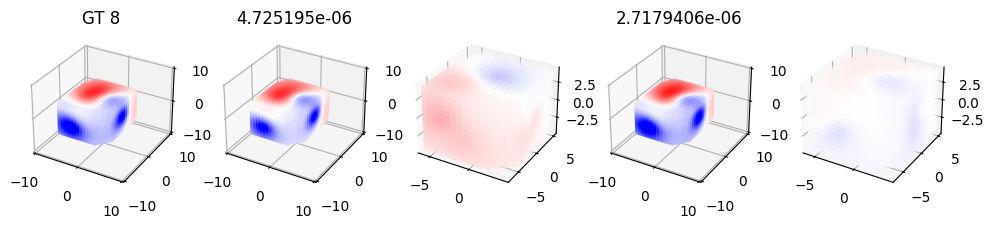

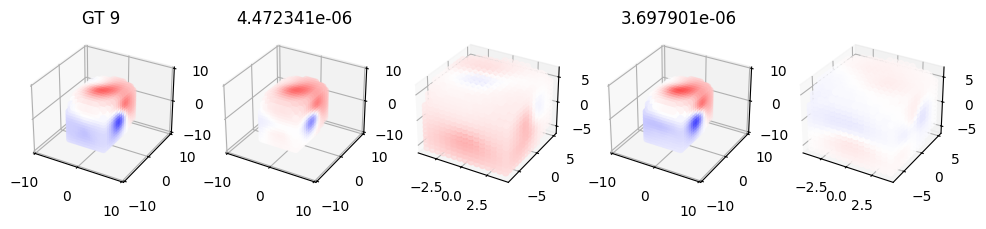

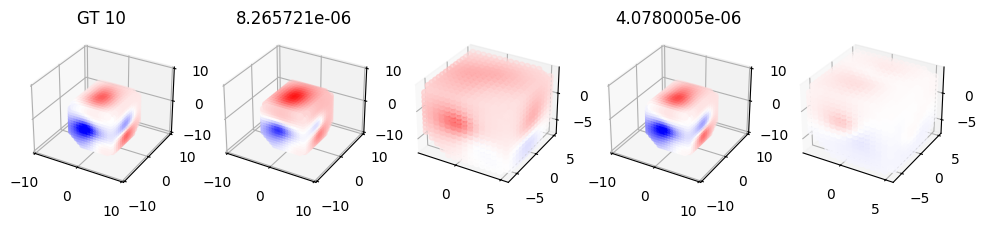

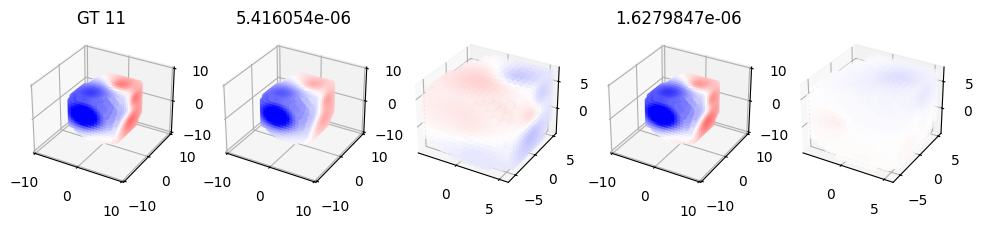

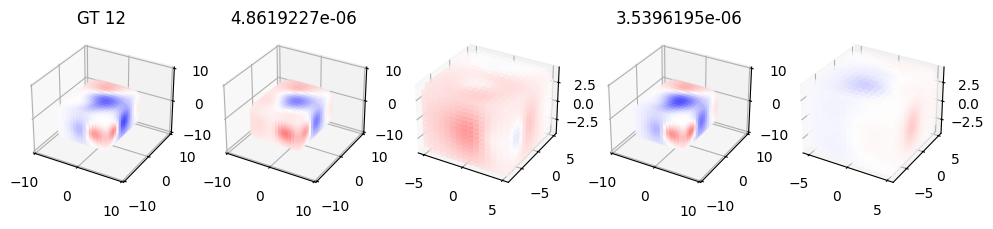

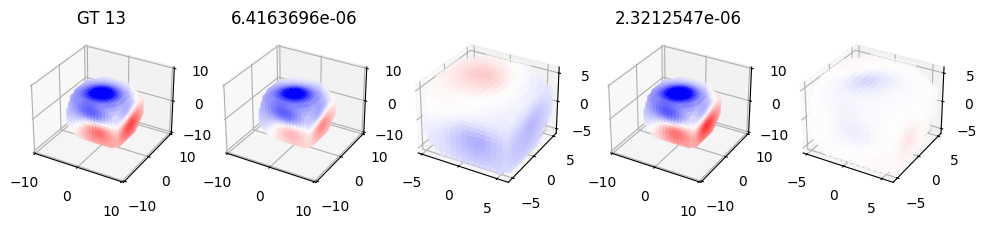

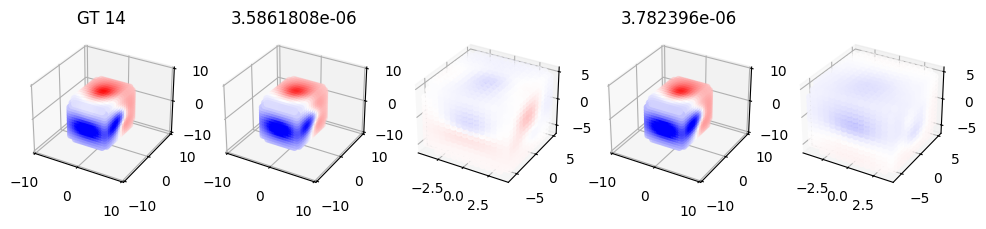

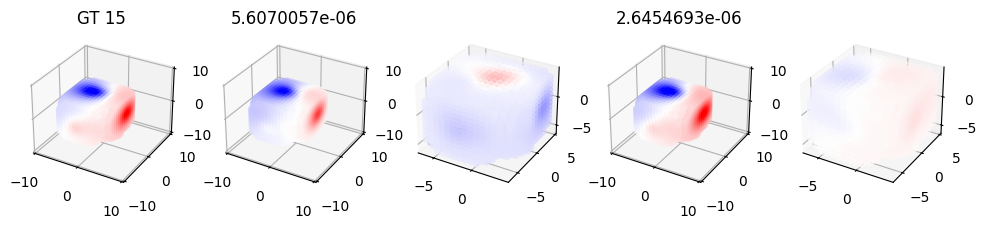

In [781]:
errors_train = []

for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size)
    errors_train.append(errors)

In [813]:
def flatten(xss):
    return [x for xs in xss for x in xs]
    
def process_df(errors):
    h2kcal = 627.509
    df = pd.DataFrame(flatten(errors))
    df["model"] = df[0].apply(lambda x: np.sqrt(x)*h2kcal)
    df["mono"] = df[1].apply(lambda x: np.sqrt(x)*h2kcal)
    return df

In [825]:
errors_test = []

for batchID in range(10):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size)
    errors_test.append(errors)

In [826]:
dcm1_errors = process_df(errors_test)

In [828]:
dcm1_errors.describe()

model        mono
count  160.000000  160.000000
mean     1.607379    1.010225
std      0.605903    0.300919
min      0.708375    0.585790
25%      1.176124    0.803331
50%      1.472689    0.941258
75%      1.893197    1.123886
max      4.839433    2.416022

# DCM2

In [892]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 2
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle("checkpoints/dcm2-10000.0/15-0.06003826856613159-esp_params.pkl")

params = pd.read_pickle("checkpoints/dcm2-10000.0/7-0.0513247549533844-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm2-10.0/60-0.0001514391478849575-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm2-1000.0/1-0.005339722149074078-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm2-1000.0/3-0.006216590758413076-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm2-100.0/22-0.0007790759555064142-esp_params.pkl")



message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 2
)

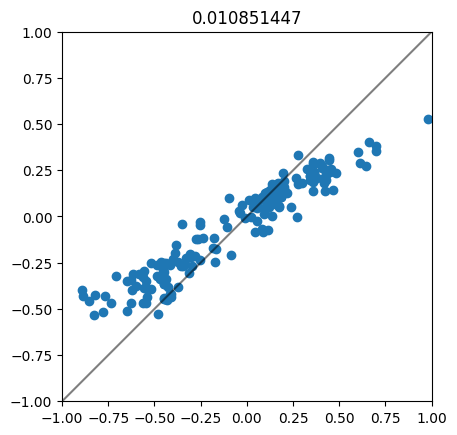

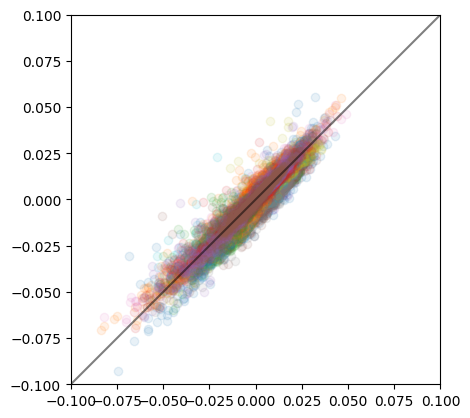

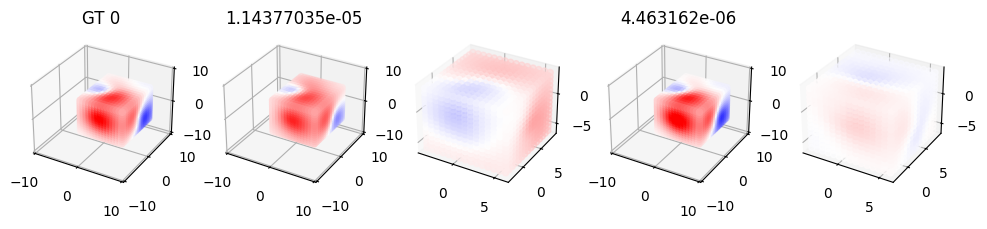

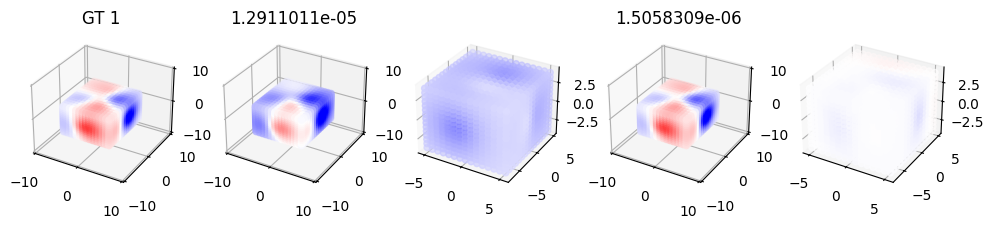

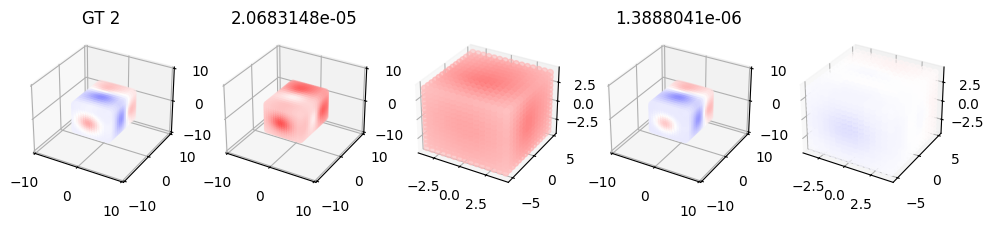

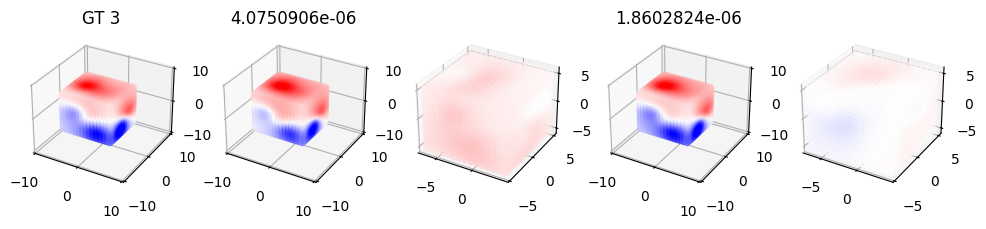

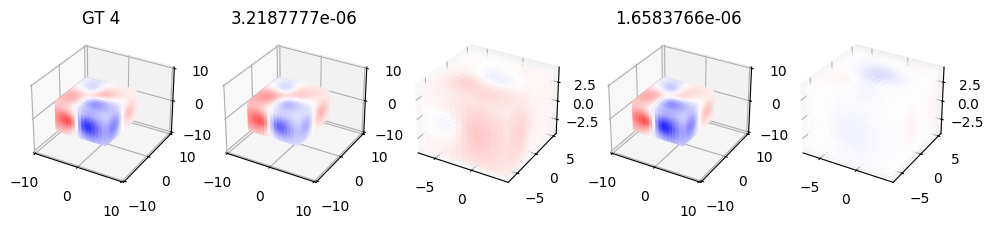

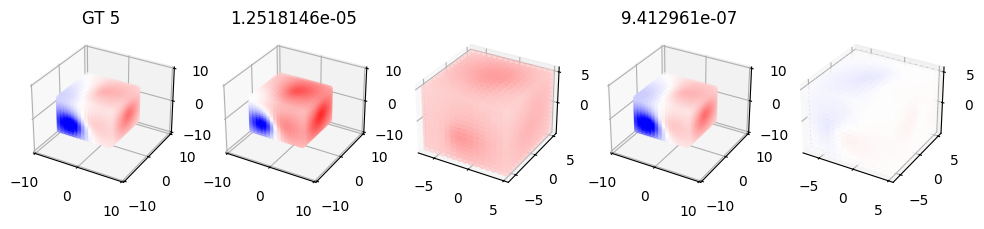

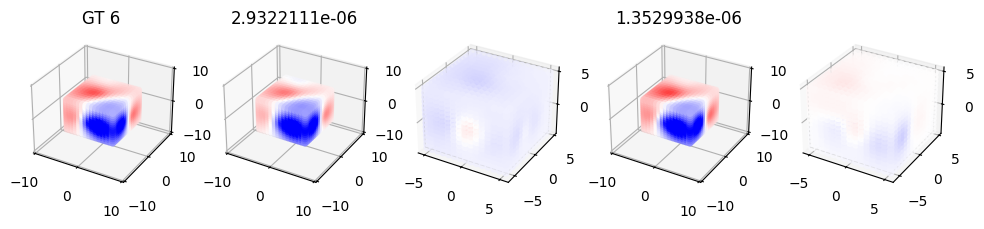

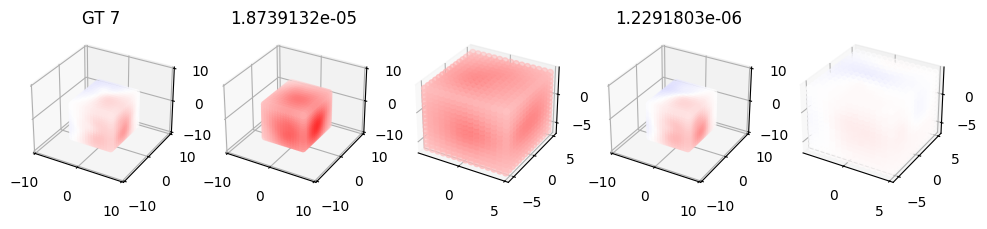

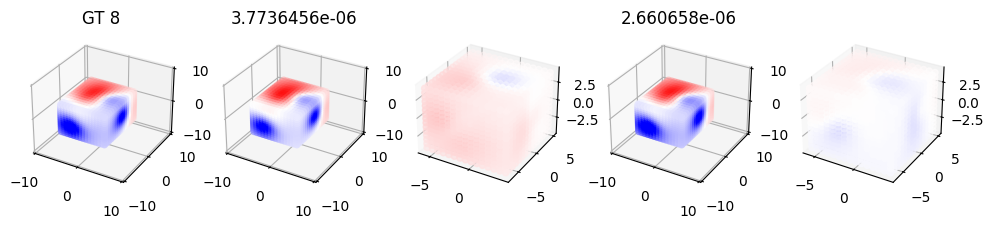

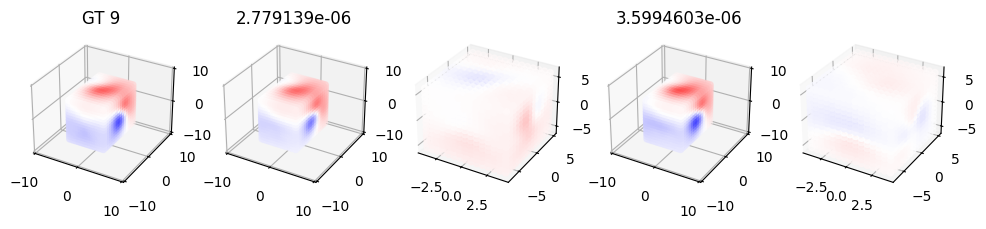

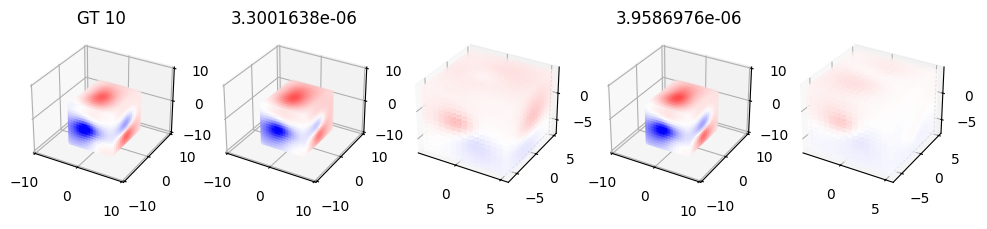

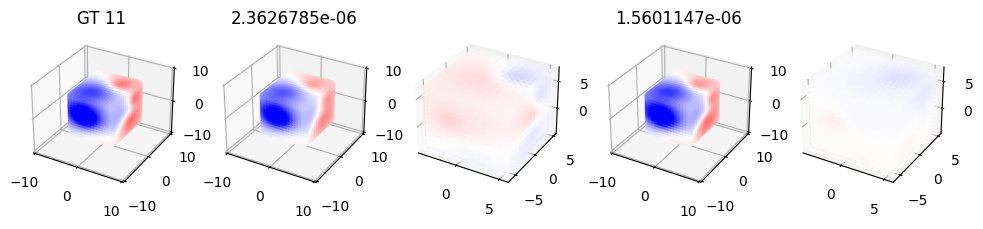

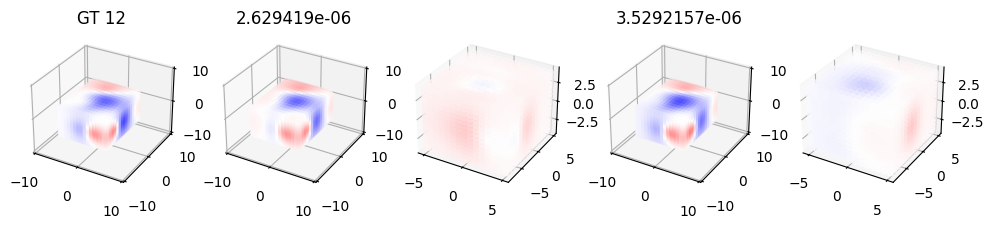

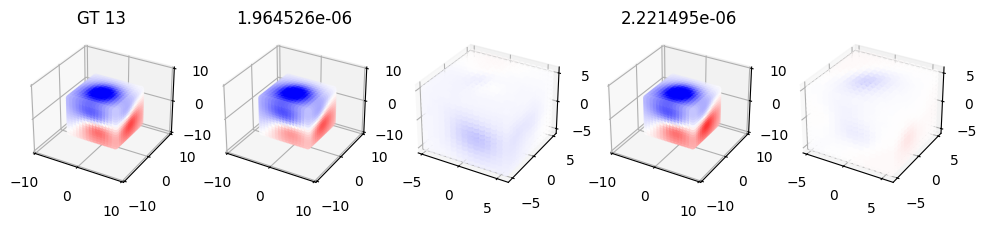

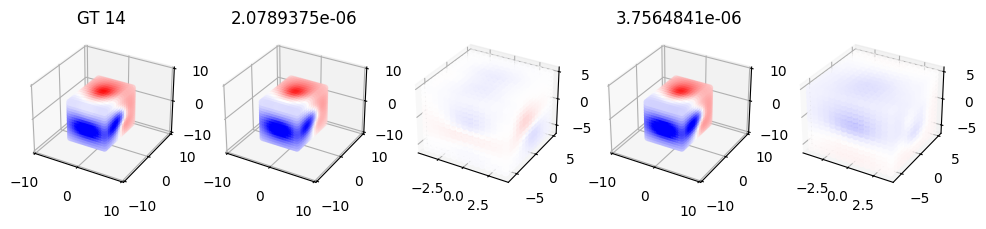

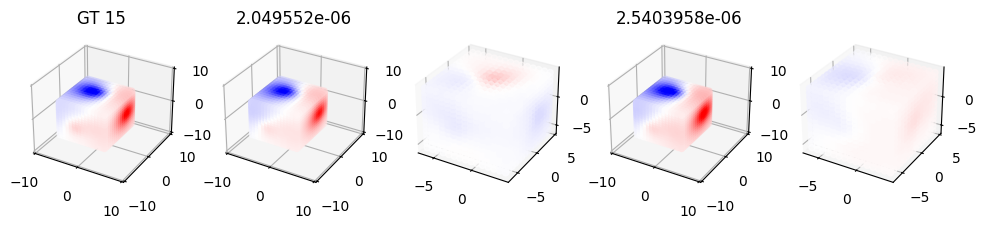

In [893]:
for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size, plot=True)

In [ ]:
test_error = []

for batchID in range(len(train_batches)):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    error = evaluate_dc(batch, dipo, mono, batch_size)
    test_error.append(error)

In [ ]:
dcm2_errors = process_df(test_error)

In [ ]:
dcm2_errors.describe()

In [ ]:
plt.hist(dcm2_errors["mono"], alpha=0.5)
plt.hist(dcm2_errors["model"], alpha=0.5)
plt.xlim(0, 5)

#  DCM3

In [842]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 3
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle("checkpoints/dcm3-10000.0/15-0.028422720730304718-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-10.0/17-0.0001334990083705634-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-1000.0/1-0.0064852177165448666-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-100.0/14-0.0007971551967784762-esp_params.pkl")
message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 3
)

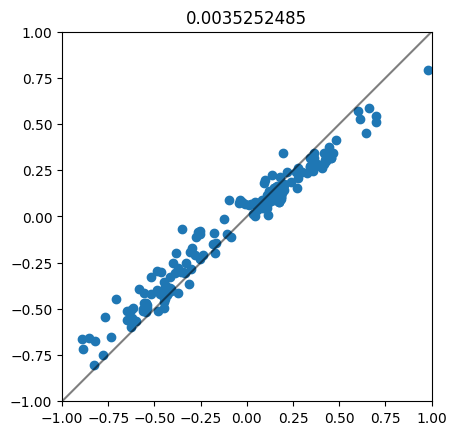

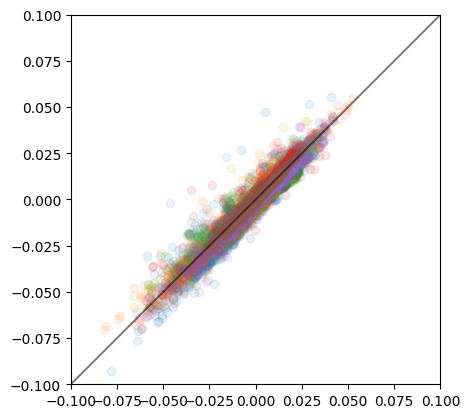

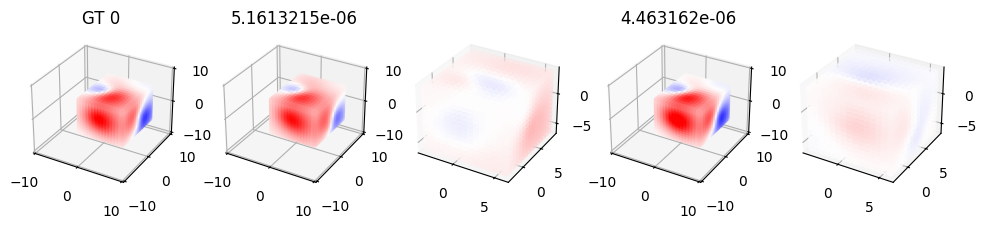

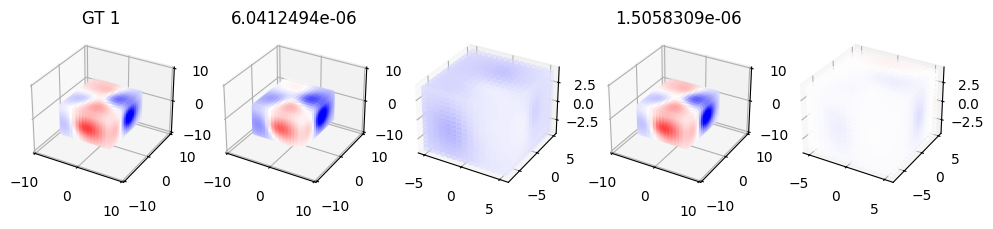

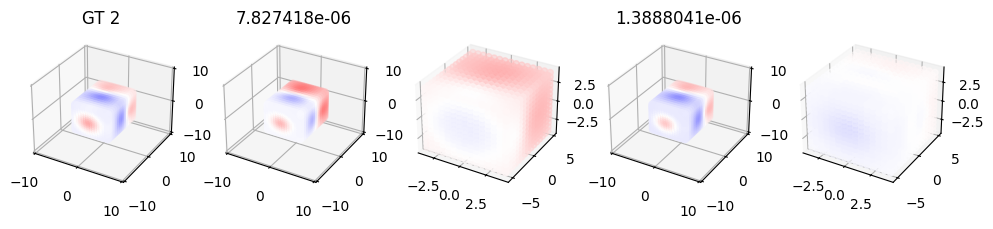

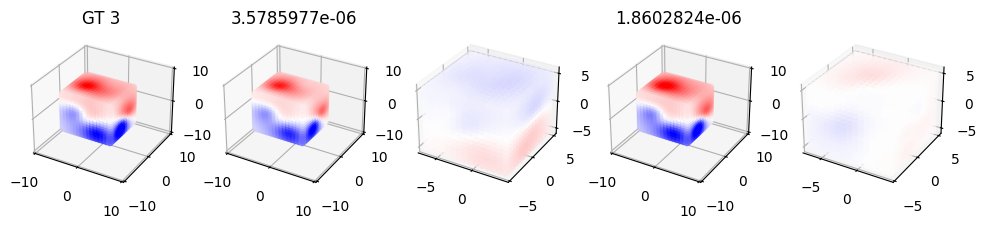

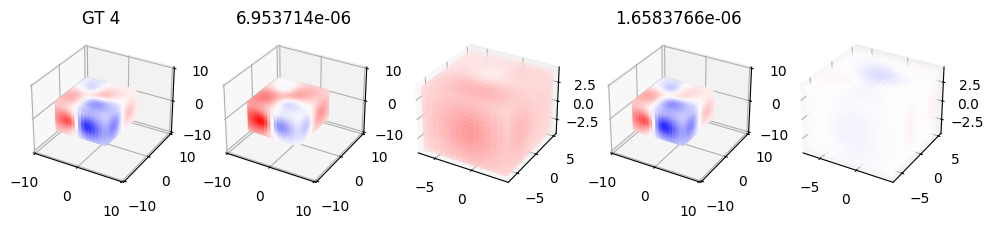

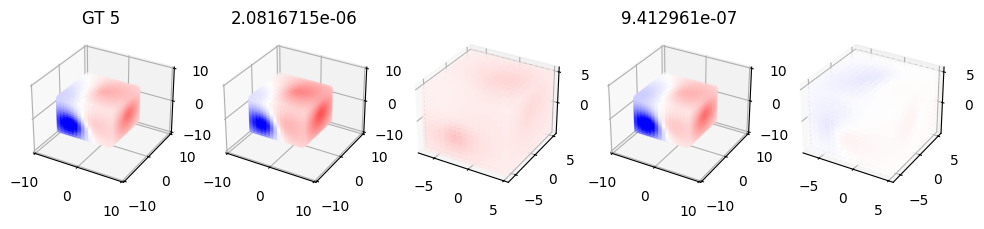

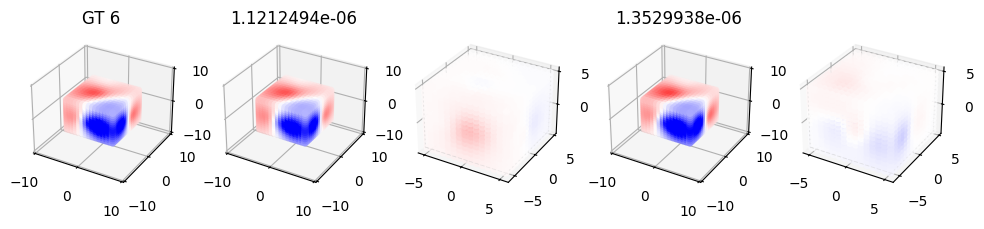

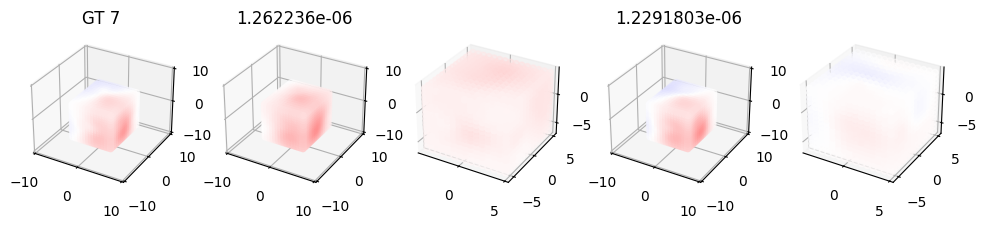

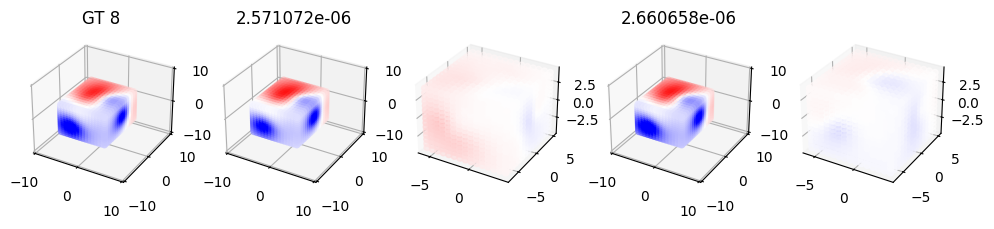

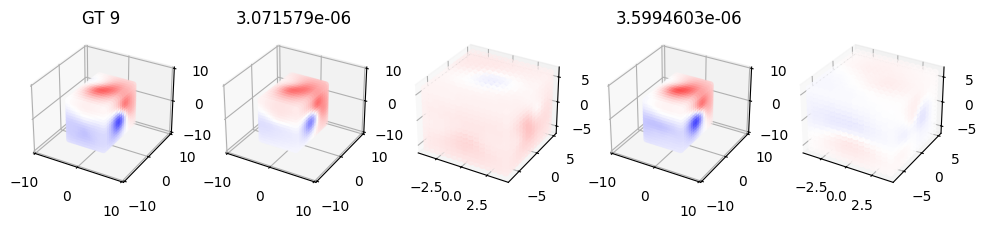

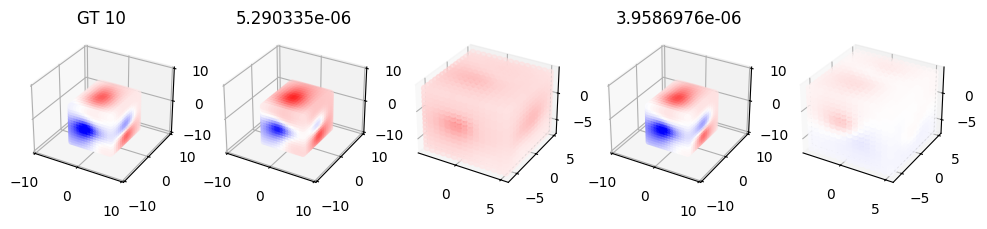

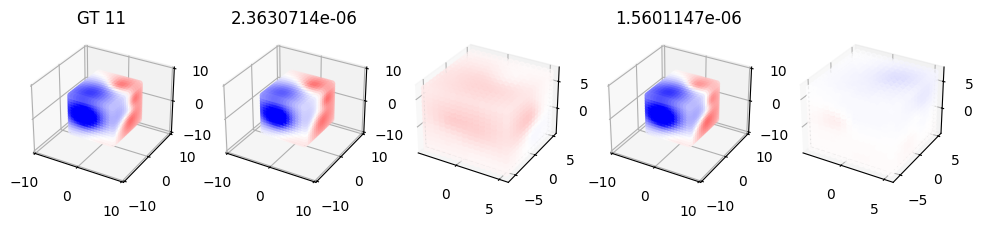

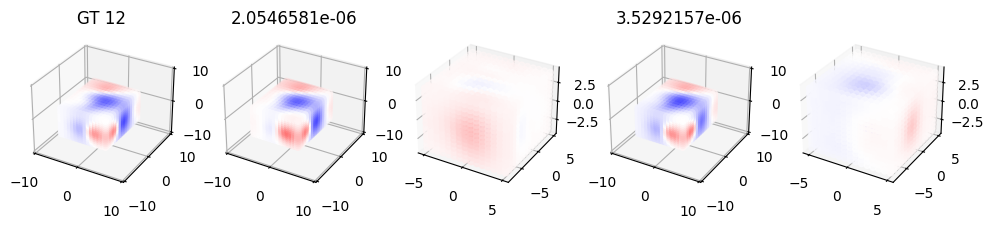

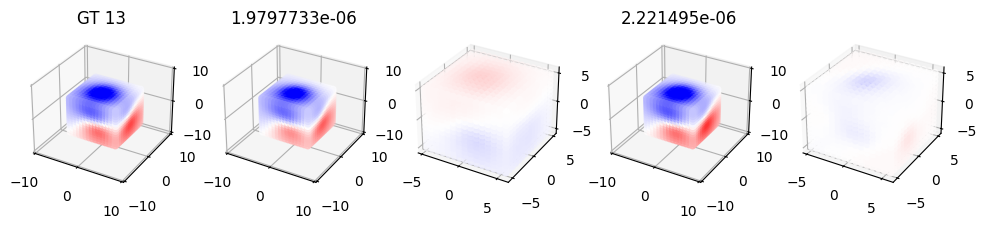

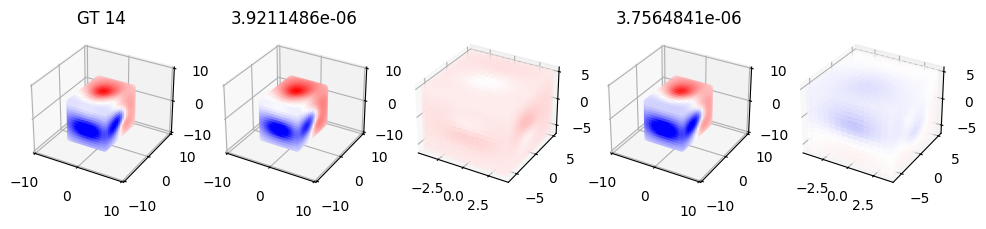

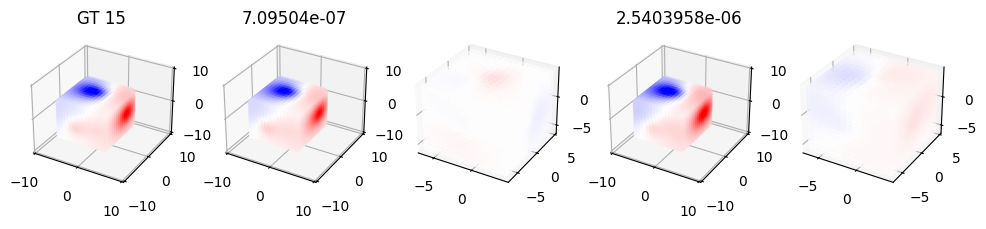

In [843]:
for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size, plot=True)

In [848]:
test_errors = []

for batchID in range(10):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size)
    test_errors.append(errors)

In [849]:
dcm3_errors = process_df(test_errors)

In [850]:
dcm3_errors.describe()

model        mono
count  160.000000  160.000000
mean     1.049764    0.991932
std      0.545726    0.302628
min      0.344332    0.575327
25%      0.705065    0.781919
50%      0.894752    0.930764
75%      1.233525    1.102562
max      4.673794    2.408801

(0.0, 5.0)

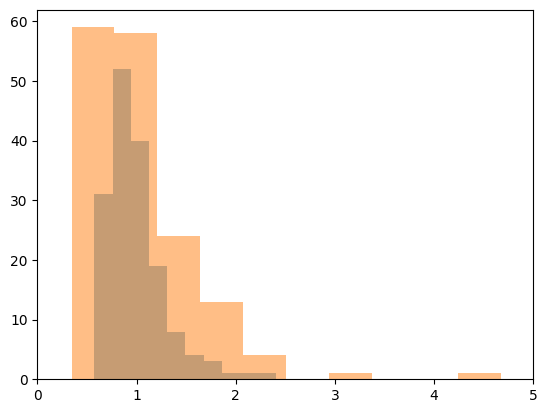

In [854]:
plt.hist(dcm3_errors["mono"], alpha=0.5)
plt.hist(dcm3_errors["model"], alpha=0.5)
plt.xlim(0, 5)

#  DCM4

In [868]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 4
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle("checkpoints/dcm4-10000.0/15-0.025600841268897057-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm4-10.0/17-0.00013063110236544162-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm4-100.0/14-0.0007527425768785179-esp_params.pkl")
# 

message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 4
)

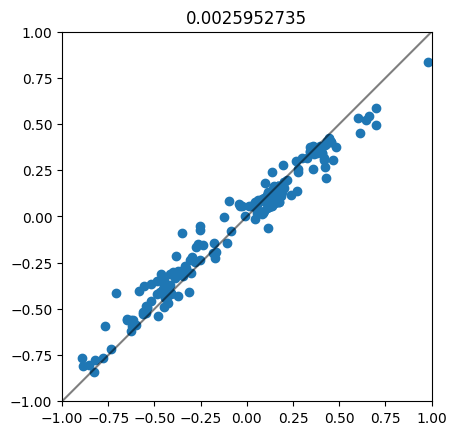

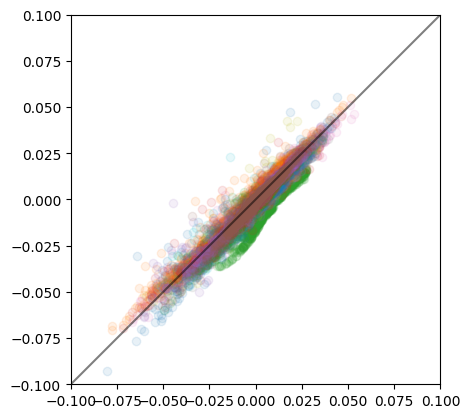

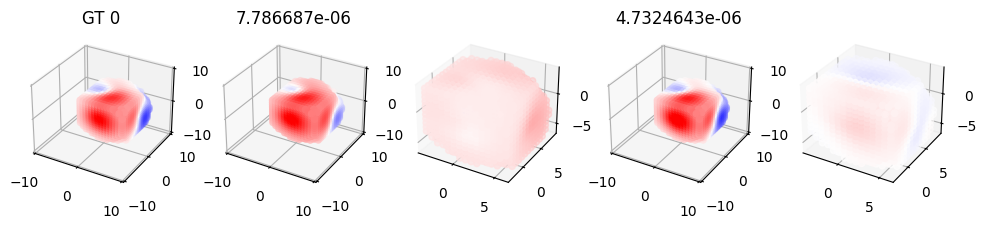

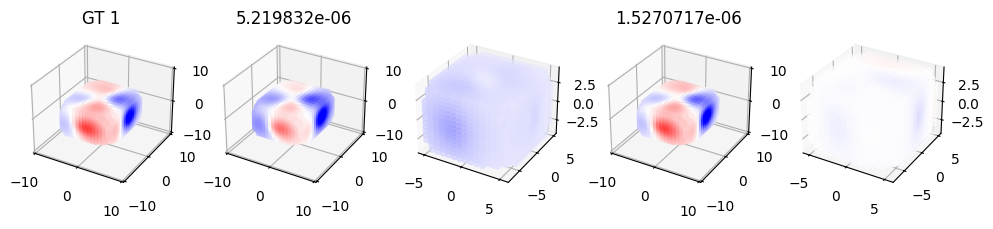

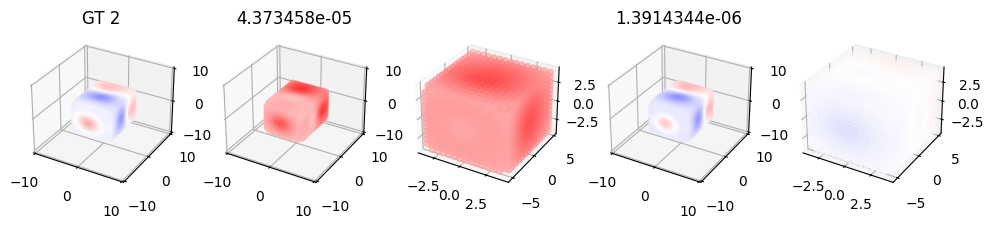

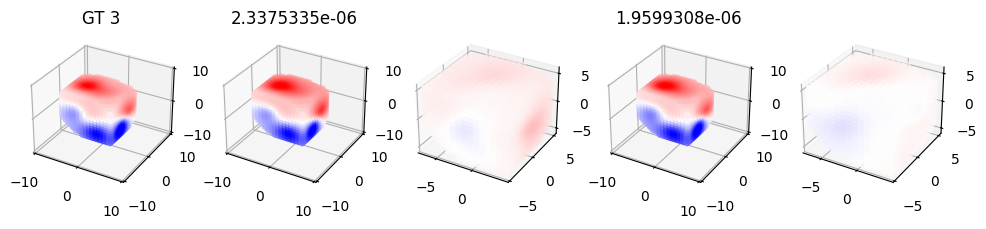

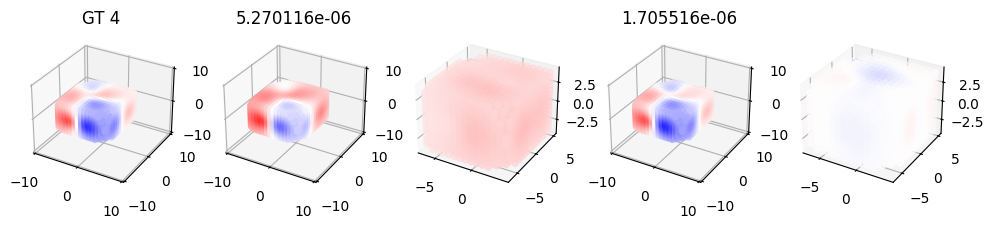

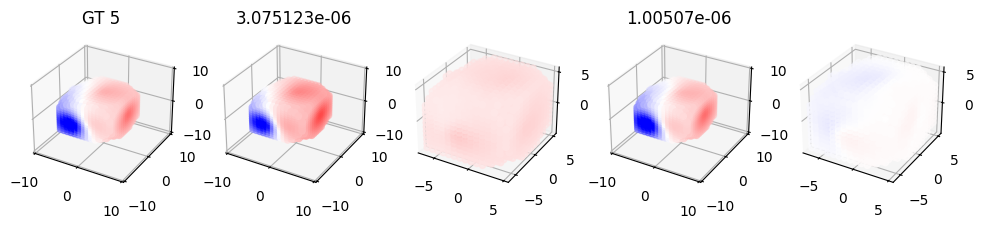

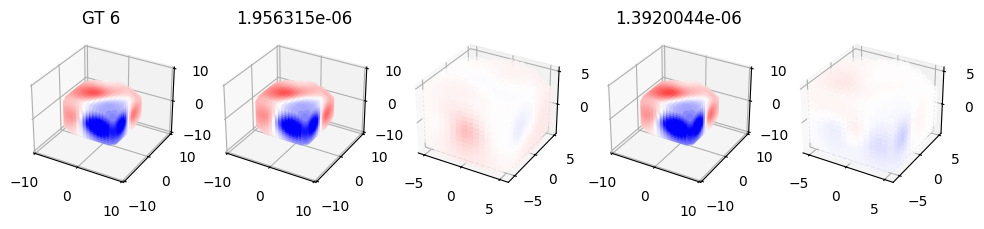

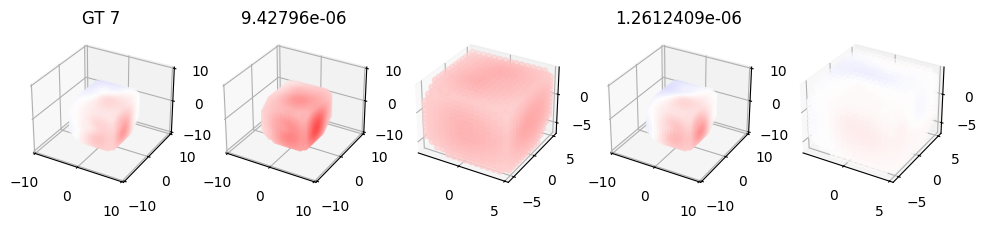

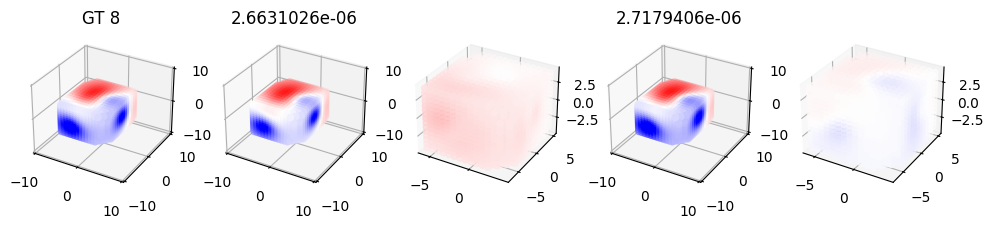

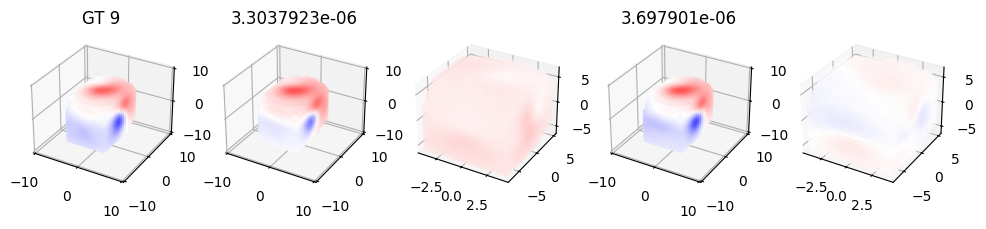

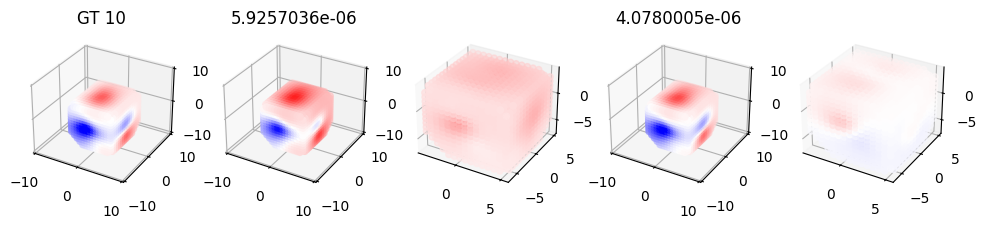

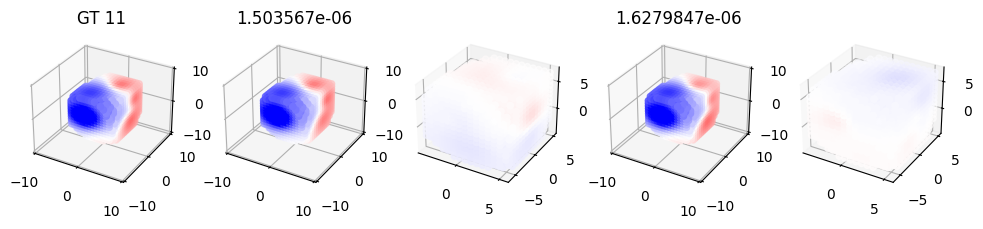

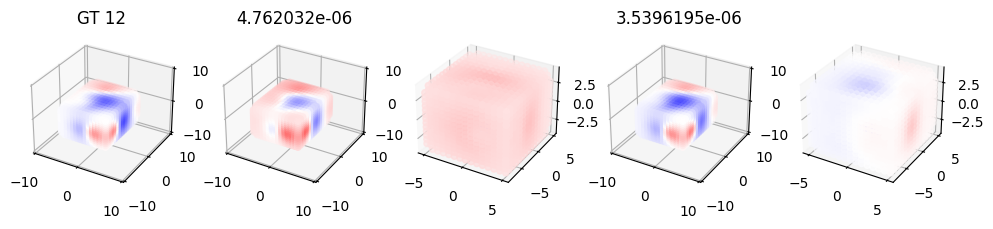

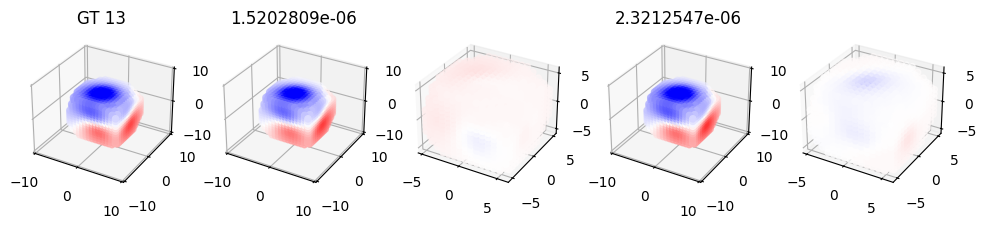

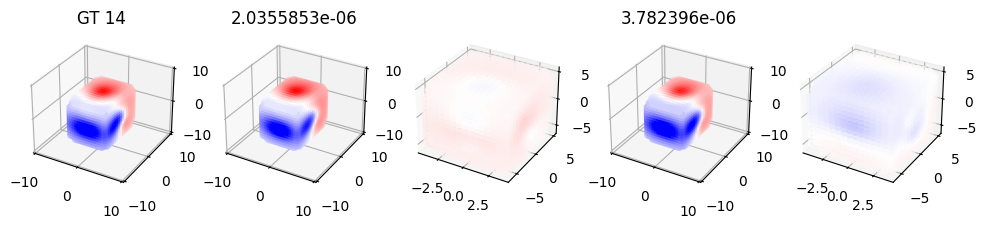

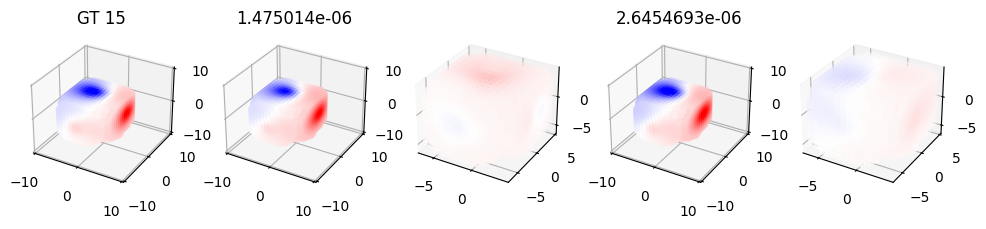

In [747]:
for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size, plot=True)

In [869]:
test_errors = []

for batchID in range(10):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size)
    test_errors.append(errors)

In [870]:
dcm4_errors = process_df(test_errors)

In [871]:
dcm4_errors.describe()

model        mono
count  160.000000  160.000000
mean     1.040123    0.991932
std      0.473789    0.302628
min      0.442833    0.575327
25%      0.760029    0.781919
50%      0.932828    0.930764
75%      1.230094    1.102562
max      3.832173    2.408801

(0.0, 5.0)

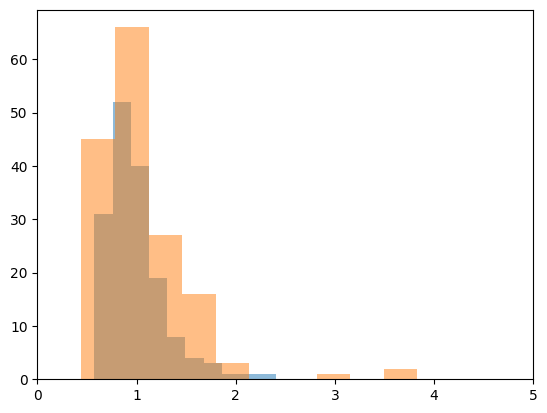

In [872]:
plt.hist(dcm4_errors["mono"], alpha=0.5)
plt.hist(dcm4_errors["model"], alpha=0.5)
plt.xlim(0, 5)

# Equivariance 

In [271]:
key, rotation_key = jax.random.split(data_key)
rotation = e3x.so3.random_rotation(rotation_key)
rotation

for batchID in [0]:
    batch = train_batches[batchID]
    
    mono_rot, dipo_rot = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions']@rotation,
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    # evaluate_dc(batch, dipo, mono, batch_size)

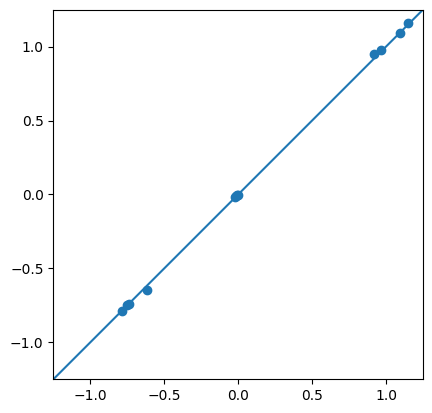

In [306]:
plt.scatter((dipo[0].T  @ rotation).flatten(), dipo_rot[0].T.flatten() )
plt.plot([-2,2],[-2,2])
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
ax = plt.gca()
ax.set_aspect("equal")

#  Structures

In [855]:
i = 15
a1_ = mono.reshape(batch_size, 60, n_dcm)[i]
b1_ = batch['atomic_numbers'].reshape(batch_size, 60)[i]
c1_ = batch["mono"].reshape(batch_size, 60)[i]
nonzero = np.nonzero(c1_)

total = 0.0
total_mono = 0.0

for j, l, k in zip(a1_[nonzero], b1_[nonzero], c1_[nonzero]):
    print(j, j.sum(), l, k, abs(j.sum() - k))
    total += j.sum()
    total_mono += k
    
print(total, total_mono)
dc = dipo.reshape(batch_size,60,3,n_dcm)
dc = np.moveaxis(dc, -1, -2)
dc = dc.reshape(batch_size, 60*n_dcm, 3)
dcq = mono.reshape(batch_size,60*n_dcm,1)
dcq = np.moveaxis(dcq, -1, -2)
dcq = dcq.reshape(batch_size, 60*n_dcm, 1)

[ 0.01692894 -0.37591848 -0.08262567] -0.44161522 6 -0.46092942 0.0193142
[ 0.06117102  0.17197159 -0.04340205] 0.18974057 6 0.1506118 0.039128765
[ 0.04524447 -0.22165507 -0.09599337] -0.27240396 6 -0.43700084 0.16459689
[ 0.35115924  0.05803287 -0.07881157] 0.33038056 6 0.4671239 0.13674334
[-0.0520124  -0.3070978  -0.04502119] -0.40413138 8 -0.4581163 0.05398491
[ 0.01794468 -0.26691747 -0.05150025] -0.30047303 6 -0.3829045 0.082431465
[ 0.0336517  -0.30379403 -0.03730556] -0.30744788 6 -0.35011223 0.04266435
[-1.3864638e-02  1.4568835e-01 -1.4153682e-04] 0.13168219 1 0.15043691 0.01875472
[ 0.01375389  0.13560255 -0.01603679] 0.13331965 1 0.14898117 0.015661523
[-0.01152953  0.14018956  0.00332797] 0.131988 1 0.14739242 0.015404418
[-0.03615846  0.10374352  0.03868   ] 0.10626507 1 0.17120571 0.06494065
[-0.00326949  0.11545964  0.00428773] 0.11647788 1 0.17123367 0.054755792
[-0.00541234  0.05361343  0.01061448] 0.05881557 1 0.026363002 0.03245257
[ 0.02162326  0.1388303  -0.03246

In [859]:
xyz = batch['positions'].reshape(batch_size,60,3)[i][nonzero]
elem = batch["atomic_numbers"].reshape(batch_size,60)[i][nonzero]
from ase import Atoms
from ase.visualize import view
mol = Atoms(elem, xyz)
view(mol, viewer="x3d")

In [860]:
idx = len(nonzero[0])*n_dcm
dcmol = Atoms(["X" if _ > 0 else "He" for _ in dcq[i][:idx]], dc[i][:idx])
view(dcmol, viewer="x3d")

In [858]:
combined = dcmol + mol
view(combined, viewer="x3d")

In [745]:
(dipo - batch['positions'][:,:,None]).reshape(batch_size, 60, 3, n_dcm)[i][nonzero]

Array([[[-1.49099529e-02,  8.19110870e-03, -1.04571193e-01],
        [-3.00000072e-01,  9.80244875e-02, -3.00000072e-01],
        [-9.06351209e-02,  8.45244527e-03, -5.29760718e-02]],

       [[ 1.24747567e-01, -4.04502861e-02, -2.75990516e-01],
        [ 9.40628201e-02,  2.08636411e-02,  8.54385048e-02],
        [ 9.42096114e-03, -6.79371879e-02, -6.29957467e-02]],

       [[ 1.00219190e-01, -2.23802924e-02, -4.92778420e-02],
        [-1.28648281e-01, -2.99857855e-02,  9.80273485e-02],
        [ 2.99999952e-01, -6.65446520e-02,  4.16748524e-02]],

       [[ 5.82801104e-02, -1.60454512e-02, -3.76363993e-02],
        [ 1.20391130e-01, -3.81326675e-02, -1.47074699e-01],
        [ 4.84866202e-02, -4.45562601e-03,  1.92242861e-03]],

       [[-2.76484728e-01, -1.56376362e-02, -2.49388218e-02],
        [-4.15716171e-02, -2.32491493e-02, -1.85454369e-01],
        [ 2.00276583e-01,  3.17066610e-02,  2.43023917e-01]],

       [[ 1.02095604e-02,  5.61199188e-02, -7.53676891e-02],
        [-5.36